# 2b_sign_condition_Liam.ipynb

## Sign Condition Classification for Maltese Traffic Signs

**Student:** Liam  
**Attribute:** Sign Condition  
**Task:** Classify cropped traffic sign images into condition categories

### Classes:
1. Good
2. Weathered
3. Heavily_Damaged

### Approach:
- Use bounding boxes from annotations to crop sign regions
- Train a CNN classifier (ResNet18) on cropped images
- Handle class imbalance with weighted loss

## 1. Setup & Imports

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Using device: cuda


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict, Counter
import random
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("All imports successful!")

All imports successful!


In [ ]:
# Dataset paths
BASE_PATH = "/content/drive/MyDrive/ARI3129_CV_Project"
IMAGES_DIR = os.path.join(BASE_PATH, "images")
ANNOTATIONS_FILE = os.path.join(BASE_PATH, "mtsd_with_prefixes.json")

# Verify paths exist
assert os.path.exists(IMAGES_DIR), f"Images directory not found: {IMAGES_DIR}"
assert os.path.exists(ANNOTATIONS_FILE), f"Annotations file not found: {ANNOTATIONS_FILE}"

print(f"Images directory: {IMAGES_DIR}")
print(f"Annotations file: {ANNOTATIONS_FILE}")

Images directory: /content/drive/MyDrive/ARI3129_CV_Project/images
Annotations file: /content/drive/MyDrive/ARI3129_CV_Project/mtsd_with_prefixes.json


## 2. Load and Explore Data

In [ ]:
# Load COCO annotations
with open(ANNOTATIONS_FILE, 'r') as f:
    coco_data = json.load(f)

print(f"Total images: {len(coco_data['images'])}")
print(f"Total annotations: {len(coco_data['annotations'])}")

Total images: 484
Total annotations: 496


In [ ]:
# Extract sign condition labels from annotations

CONDITION_CLASSES = ['Good', 'Weathered', 'Heavily_Damaged']
CONDITION_TO_IDX = {c: i for i, c in enumerate(CONDITION_CLASSES)}

# Build image ID to filename mapping
img_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Extract condition annotations
condition_data = []  # List of (image_path, bbox, condition_label)

for ann in coco_data['annotations']:
    attributes = ann.get('attributes', {})
    condition = attributes.get('sign_condition', '')

    # Normalize condition label
    condition = condition.replace(' ', '_')
    if condition == 'Heavily_Damaged' or condition == 'Heavily Damaged':
        condition = 'Heavily_Damaged'

    if condition in CONDITION_TO_IDX:
        img_filename = img_id_to_filename.get(ann['image_id'], '')
        img_path = os.path.join(IMAGES_DIR, img_filename)

        if os.path.exists(img_path):
            condition_data.append({
                'image_path': img_path,
                'bbox': ann['bbox'],  # [x, y, width, height]
                'condition': condition,
                'label': CONDITION_TO_IDX[condition]
            })

print(f"Total samples with condition labels: {len(condition_data)}")

Total samples with condition labels: 325



Sign Condition Distribution:
  Good: 257 (79.1%)
  Weathered: 55 (16.9%)
  Heavily_Damaged: 13 (4.0%)


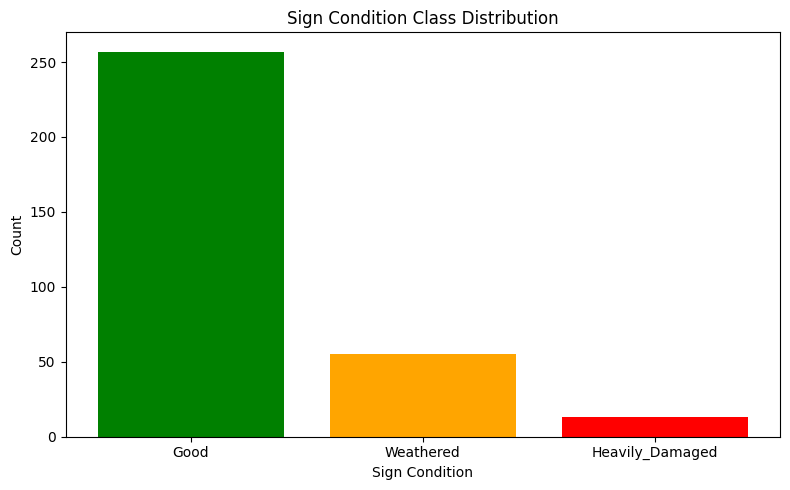


⚠️ Note: Class imbalance detected! Will use weighted loss.


In [ ]:
# Class distribution
condition_counts = Counter([d['condition'] for d in condition_data])

print("\nSign Condition Distribution:")
for condition, count in condition_counts.most_common():
    print(f"  {condition}: {count} ({100*count/len(condition_data):.1f}%)")

# Plot distribution
plt.figure(figsize=(8, 5))
plt.bar(condition_counts.keys(), condition_counts.values(), color=['green', 'orange', 'red'])
plt.xlabel('Sign Condition')
plt.ylabel('Count')
plt.title('Sign Condition Class Distribution')
plt.tight_layout()
plt.show()

print("\n Note: Class imbalance detected! Will use weighted loss.")

## 3. Dataset Class

In [ ]:
class SignConditionDataset(Dataset):

    def __init__(self, data, transform=None, padding=10):

        self.data = data
        self.transform = transform
        self.padding = padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load image
        img = Image.open(item['image_path']).convert('RGB')
        img_width, img_height = img.size

        # Get bounding box [x, y, width, height]
        x, y, w, h = item['bbox']

        # Add padding and ensure within image bounds
        x1 = max(0, int(x - self.padding))
        y1 = max(0, int(y - self.padding))
        x2 = min(img_width, int(x + w + self.padding))
        y2 = min(img_height, int(y + h + self.padding))

        # Crop the sign region
        crop = img.crop((x1, y1, x2, y2))

        if self.transform:
            crop = self.transform(crop)

        label = item['label']

        return crop, label

print("Dataset class defined!")

Dataset class defined!


In [ ]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined!")

Transforms defined!


## 4. Train/Val/Test Split

In [ ]:
# Stratified split to maintain class distribution
labels = [d['label'] for d in condition_data]

# First split: train+val vs test (70/30)
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    condition_data, labels, test_size=0.15, random_state=42, stratify=labels
)

# Second split: train vs val
train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, train_val_labels, test_size=0.176, random_state=42, stratify=train_val_labels
)  # 0.176 of 85% ≈ 15% of total

print(f"Train set: {len(train_data)} samples")
print(f"Val set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

# Check distribution in each split
for name, data in [('Train', train_data), ('Val', val_data), ('Test', test_data)]:
    counts = Counter([d['condition'] for d in data])
    print(f"\n{name} distribution:")
    for c in CONDITION_CLASSES:
        print(f"  {c}: {counts.get(c, 0)}")

Train set: 227 samples
Val set: 49 samples
Test set: 49 samples

Train distribution:
  Good: 179
  Weathered: 39
  Heavily_Damaged: 9

Val distribution:
  Good: 39
  Weathered: 8
  Heavily_Damaged: 2

Test distribution:
  Good: 39
  Weathered: 8
  Heavily_Damaged: 2


In [ ]:
# Create datasets
train_dataset = SignConditionDataset(train_data, transform=train_transform)
val_dataset = SignConditionDataset(val_data, transform=val_transform)
test_dataset = SignConditionDataset(test_data, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Datasets and loaders created!")

Datasets and loaders created!


Sample cropped signs from training set:


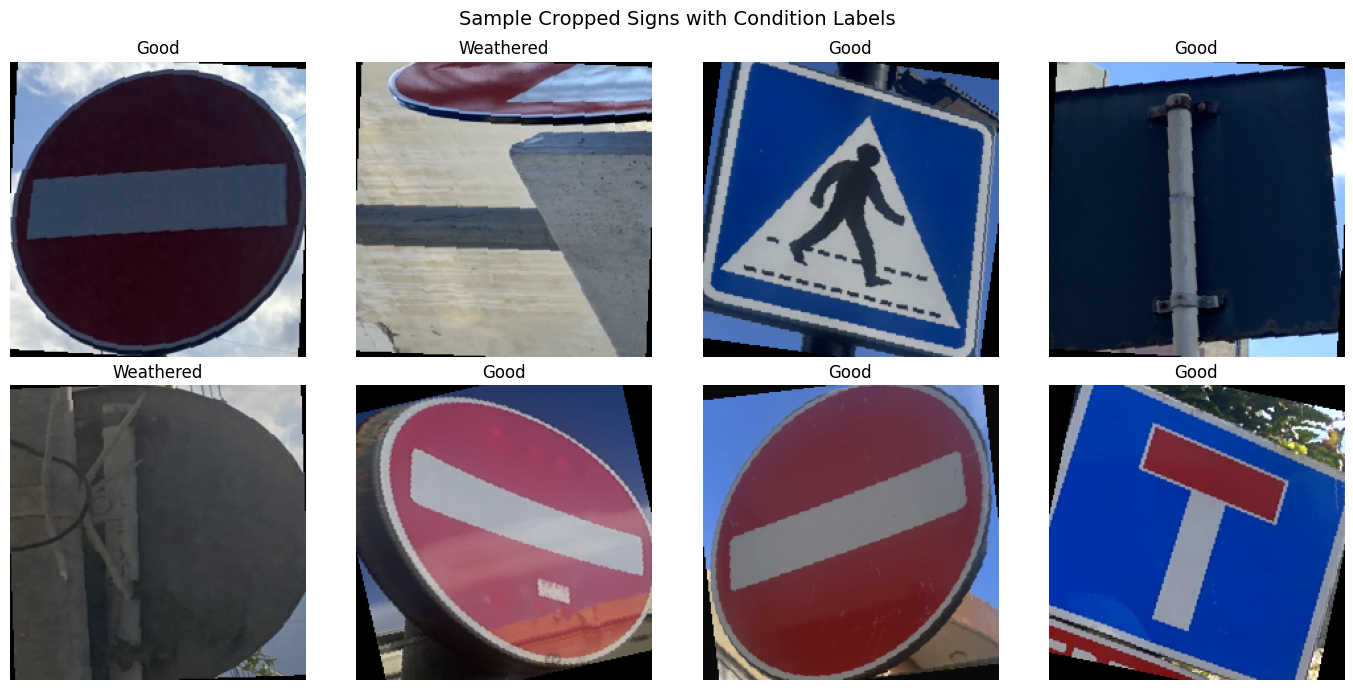

In [ ]:
# Visualize some samples
def show_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    axes = axes.flatten()

    # Denormalize for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]
        img = img * std + mean  # Denormalize
        img = img.permute(1, 2, 0).numpy().clip(0, 1)

        ax.imshow(img)
        ax.set_title(f'{CONDITION_CLASSES[label]}', fontsize=12)
        ax.axis('off')

    plt.suptitle('Sample Cropped Signs with Condition Labels', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Sample cropped signs from training set:")
show_samples(train_dataset)

## 5. Model Setup

In [ ]:
# Calculate class weights for imbalanced data
train_label_counts = Counter([d['label'] for d in train_data])
total_samples = sum(train_label_counts.values())

# Inverse frequency weighting
class_weights = []
for i in range(len(CONDITION_CLASSES)):
    count = train_label_counts.get(i, 1)
    weight = total_samples / (len(CONDITION_CLASSES) * count)
    class_weights.append(weight)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights.cpu().numpy()}")
for i, c in enumerate(CONDITION_CLASSES):
    print(f"  {c}: {class_weights[i].item():.3f}")

Class weights: [0.42271882 1.9401709  8.407408  ]
  Good: 0.423
  Weathered: 1.940
  Heavily_Damaged: 8.407


In [ ]:
# Load pretrained ResNet18 and modify for our classes
model = models.resnet18(pretrained=True)

# Freeze early layers (optional - can unfreeze for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(CONDITION_CLASSES))
)

# Unfreeze the fc layer
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
print(f"Model loaded with {len(CONDITION_CLASSES)} output classes")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 229MB/s]

Model loaded with 3 output classes
Trainable parameters: 1,539


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Loss function and optimizer configured!")

Loss function and optimizer configured!


## 6. Training

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("Training functions defined!")

Training functions defined!


In [ ]:
# Training loop
num_epochs = 20
best_val_acc = 0
patience = 5
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print(f"Starting training for {num_epochs} epochs...")
print("="*60)

for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.1f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.1f}% | "
          f"Time: {epoch_time:.1f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        MODEL_SAVE_PATH = os.path.join(BASE_PATH, "condition_classifier_liam.pth")
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  → Best model saved! (Val Acc: {val_acc:.1f}%)")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break

print("="*60)
print(f"Training complete! Best validation accuracy: {best_val_acc:.1f}%")

Starting training for 20 epochs...


Epoch  1/20 | Train Loss: 1.4425 Acc: 54.6% | Val Loss: 1.4130 Acc: 34.7% | Time: 166.3s
  → Best model saved! (Val Acc: 34.7%)


Epoch  2/20 | Train Loss: 1.2257 Acc: 44.1% | Val Loss: 1.2370 Acc: 63.3% | Time: 30.4s
  → Best model saved! (Val Acc: 63.3%)


Epoch  3/20 | Train Loss: 1.1969 Acc: 45.4% | Val Loss: 1.2181 Acc: 71.4% | Time: 30.6s
  → Best model saved! (Val Acc: 71.4%)


Epoch  4/20 | Train Loss: 1.1102 Acc: 59.9% | Val Loss: 1.3006 Acc: 81.6% | Time: 31.1s
  → Best model saved! (Val Acc: 81.6%)


Epoch  5/20 | Train Loss: 1.1660 Acc: 63.0% | Val Loss: 1.2742 Acc: 67.3% | Time: 31.2s


Epoch  6/20 | Train Loss: 1.0303 Acc: 55.1% | Val Loss: 1.2330 Acc: 75.5% | Time: 29.9s


Epoch  7/20 | Train Loss: 1.0364 Acc: 61.2% | Val Loss: 1.2979 Acc: 81.6% | Time: 30.2s


Epoch  8/20 | Train Loss: 0.9526 Acc: 59.0% | Val Loss: 1.2104 Acc: 79.6% | Time: 30.8s


Epoch  9/20 | Train Loss: 0.9897 Acc: 55.5% | Val Loss: 1.1888 Acc: 75.5% | Time: 30.4s

Early stopping at epoch 9
Training complete! Best validation accuracy: 81.6%


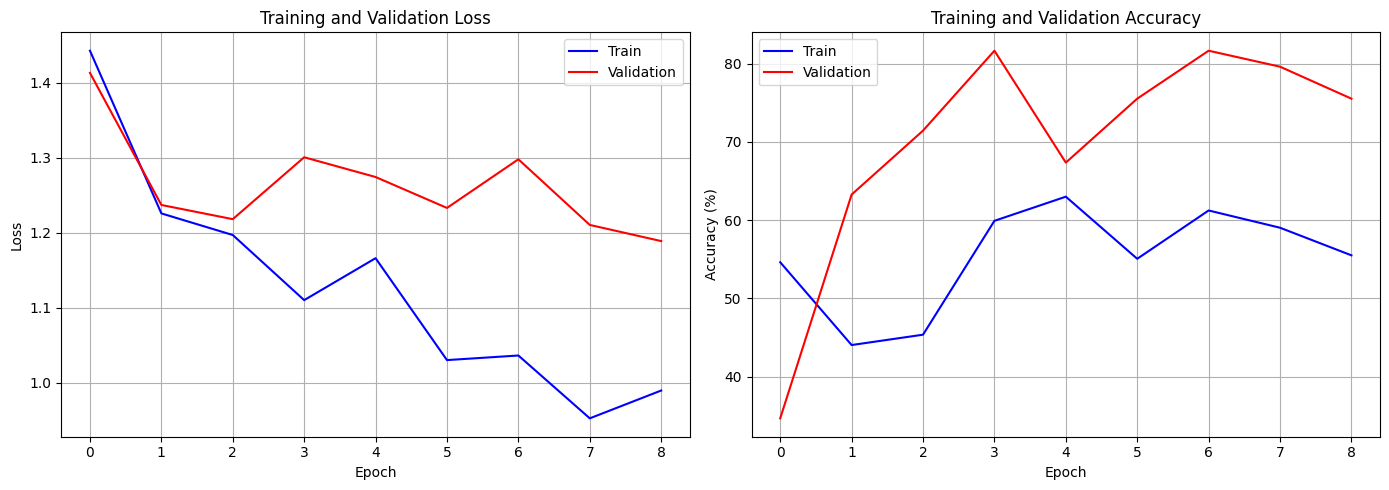

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], 'b-', label='Train')
axes[0].plot(history['val_loss'], 'r-', label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], 'b-', label='Train')
axes[1].plot(history['val_acc'], 'r-', label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluation

In [ ]:
# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()
print("Best model loaded for evaluation")

Best model loaded for evaluation


In [ ]:
# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Testing: 100%|██████████| 2/2 [00:34<00:00, 17.11s/it]


In [ ]:
# Classification report
print("="*60)
print("TEST SET RESULTS - SIGN CONDITION CLASSIFICATION")
print("="*60)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CONDITION_CLASSES))

TEST SET RESULTS - SIGN CONDITION CLASSIFICATION

Classification Report:
                 precision    recall  f1-score   support

           Good       0.80      1.00      0.89        39
      Weathered       0.00      0.00      0.00         8
Heavily_Damaged       0.00      0.00      0.00         2

       accuracy                           0.80        49
      macro avg       0.27      0.33      0.30        49
   weighted avg       0.63      0.80      0.71        49



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


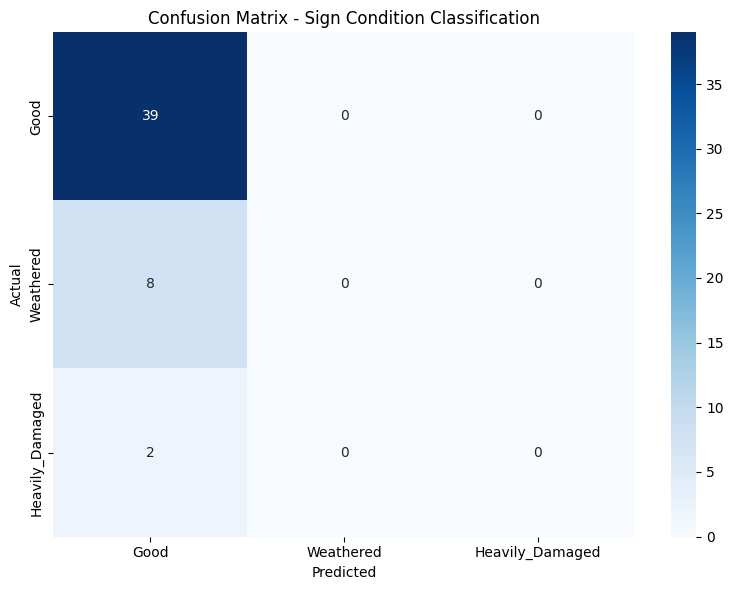

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CONDITION_CLASSES,
            yticklabels=CONDITION_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Sign Condition Classification')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate overall accuracy
test_accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)
print(f"\nOverall Test Accuracy: {test_accuracy:.2f}%")


Overall Test Accuracy: 79.59%


## 8. Visualize Predictions

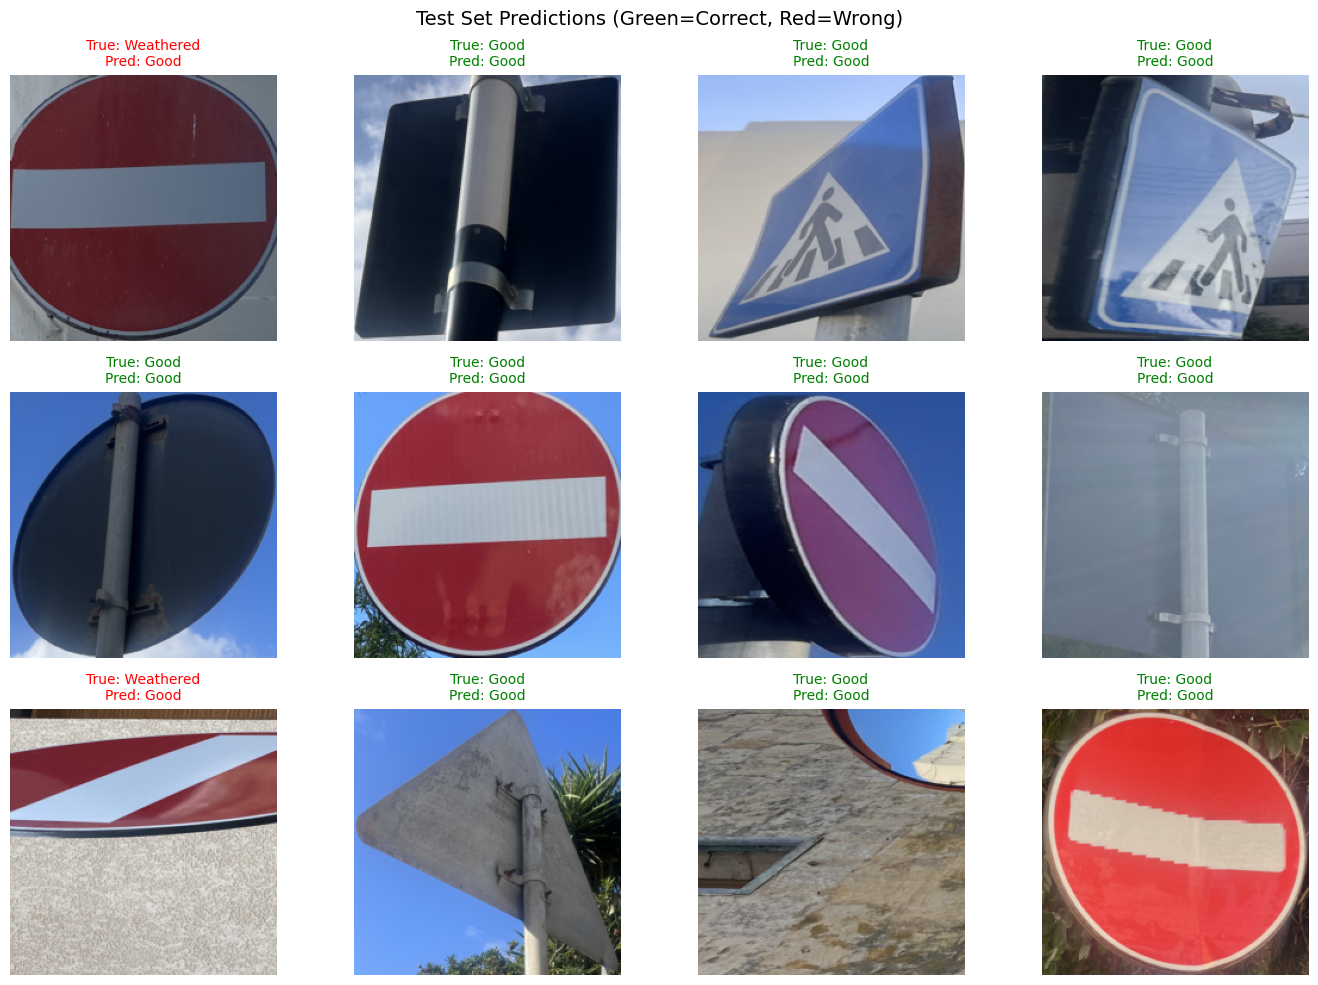

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=12):
    model.eval()

    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    axes = axes.flatten()

    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]

        # Predict
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            _, pred = output.max(1)

        # Denormalize for display
        img_display = img * std + mean
        img_display = img_display.permute(1, 2, 0).numpy().clip(0, 1)

        ax.imshow(img_display)

        true_label = CONDITION_CLASSES[label]
        pred_label = CONDITION_CLASSES[pred.item()]

        color = 'green' if label == pred.item() else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=10)
        ax.axis('off')

    plt.suptitle('Test Set Predictions (Green=Correct, Red=Wrong)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, device)

## 9. Summary & Results

In [ ]:
# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None
)

# Final summary
print("="*60)
print("SIGN CONDITION CLASSIFICATION - SUMMARY")
print("="*60)
print(f"\nStudent: Liam")
print(f"Attribute: Sign Condition")
print(f"Architecture: ResNet18 (pretrained, fine-tuned FC layer)")
print(f"\nClasses: {CONDITION_CLASSES}")
print(f"\nDataset:")
print(f"  Total samples: {len(condition_data)}")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")
print(f"\nTraining:")
print(f"  Epochs trained: {len(history['train_loss'])}")
print(f"  Best validation accuracy: {best_val_acc:.1f}%")
print(f"\nTest Results:")
print(f"  Overall Accuracy: {test_accuracy:.2f}%")
print(f"\nPer-class Performance:")
for i, c in enumerate(CONDITION_CLASSES):
    print(f"  {c}:")
    print(f"    Precision: {precision[i]:.3f}")
    print(f"    Recall: {recall[i]:.3f}")
    print(f"    F1-Score: {f1[i]:.3f}")
    print(f"    Support: {support[i]}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*60)

SIGN CONDITION CLASSIFICATION - SUMMARY

Student: Liam
Attribute: Sign Condition
Architecture: ResNet18 (pretrained, fine-tuned FC layer)

Classes: ['Good', 'Weathered', 'Heavily_Damaged']

Dataset:
  Total samples: 325
  Train: 227
  Val: 49
  Test: 49

Training:
  Epochs trained: 9
  Best validation accuracy: 81.6%

Test Results:
  Overall Accuracy: 79.59%

Per-class Performance:
  Good:
    Precision: 0.796
    Recall: 1.000
    F1-Score: 0.886
    Support: 39
  Weathered:
    Precision: 0.000
    Recall: 0.000
    F1-Score: 0.000
    Support: 8
  Heavily_Damaged:
    Precision: 0.000
    Recall: 0.000
    F1-Score: 0.000
    Support: 2

Model saved to: /content/drive/MyDrive/ARI3129_CV_Project/condition_classifier_liam.pth


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save results for comparison notebook
results = {
    'student': 'Liam',
    'attribute': 'sign_condition',
    'architecture': 'ResNet18 (pretrained)',
    'classes': CONDITION_CLASSES,
    'num_epochs': len(history['train_loss']),
    'train_history': history,
    'test_accuracy': test_accuracy,
    'per_class_metrics': {
        c: {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1': float(f1[i]),
            'support': int(support[i])
        } for i, c in enumerate(CONDITION_CLASSES)
    },
    'confusion_matrix': cm.tolist(),
    'dataset_size': {
        'total': len(condition_data),
        'train': len(train_data),
        'val': len(val_data),
        'test': len(test_data)
    },
    'class_distribution': dict(condition_counts)
}

results_path = os.path.join(BASE_PATH, "results_condition_liam.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

Results saved to: /content/drive/MyDrive/ARI3129_CV_Project/results_condition_liam.json
